In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import random
from datetime import datetime

In [380]:
# Eliminar "comas" por "espacio en blanco" y "punto y coma" por "coma"
# Abrir, leer y modificar el contenido del archivo
with open("archivo.csv", "r", encoding="utf-8") as f:
    contenido = f.read()

# Reemplazos: primero las comas por espacio, luego los puntos y coma por coma
contenido = contenido.replace(",", " ")
contenido = contenido.replace(";", ",")

# Guardar el contenido modificado en un nuevo archivo (o sobrescribir el original si quieres)
with open("rechazos_ruta.csv", "w", encoding="utf-8") as f:
    f.write(contenido)

In [381]:
# ATENCION /.\: Puede que no lea el csv si hay comas entre nombres de transportistas, etc (ELIMINAR LAS COMAS PRIMERO)
ruta = pd.read_csv('rechazos_ruta.csv')
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Subregion Comercial         8345 non-null   object 
 1   Locación                    8345 non-null   object 
 2   Ruta Troncal Dinámico       8345 non-null   object 
 3   Ruta Figura Dinámico        8345 non-null   object 
 4   Sistema de Ventas Dinámico  8345 non-null   object 
 5   Supervisor                  6875 non-null   object 
 6   VendedorCod                 8345 non-null   int64  
 7   Motivo de anulación         8345 non-null   object 
 8   Número de Pedido            8345 non-null   int64  
 9   Número de orden de carga    8335 non-null   float64
 10  Número de Guía              8345 non-null   int64  
 11  Semana                      8345 non-null   int64  
 12  Mes                         8345 non-null   object 
 13  Año                         8345 

In [382]:
# eliminar todas las columnas excepto las relevantes
ruta = ruta[[
    'Locación',
    'Ruta Troncal Dinámico',
    'Motivo de anulación',
    'Día',
    'Venta Perdida CF',
    'Cliente',
    'Transportista',
    'Nombre Vendedor',
]]
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8345 non-null   object 
 1   Ruta Troncal Dinámico  8345 non-null   object 
 2   Motivo de anulación    8345 non-null   object 
 3   Día                    8345 non-null   object 
 4   Venta Perdida CF       8345 non-null   float64
 5   Cliente                8345 non-null   object 
 6   Transportista          8345 non-null   object 
 7   Nombre Vendedor        8345 non-null   object 
dtypes: float64(1), object(7)
memory usage: 521.7+ KB
None


In [383]:
# conservar las filas que contenga las siguientes Locaciones (por si acaso lo normal es que no esten estas locaciones)
locaciones = ['06 AYA EL PEDREGAL', '38 AYA ATICO', '40 AYA CHALA', '88 AYA CAMANA']
parse_locaciones = {
    '06 AYA EL PEDREGAL': 'El Pedregal',
    '38 AYA ATICO': 'Atico',
    '40 AYA CHALA': 'Chala',
    '88 AYA CAMANA': 'Camana'
}
ruta = ruta[ruta['Locación'].isin(locaciones)]
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8345 non-null   object 
 1   Ruta Troncal Dinámico  8345 non-null   object 
 2   Motivo de anulación    8345 non-null   object 
 3   Día                    8345 non-null   object 
 4   Venta Perdida CF       8345 non-null   float64
 5   Cliente                8345 non-null   object 
 6   Transportista          8345 non-null   object 
 7   Nombre Vendedor        8345 non-null   object 
dtypes: float64(1), object(7)
memory usage: 521.7+ KB
None


In [384]:
# rellenar los valores NaN con 0
ruta = ruta.fillna(0)
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8345 non-null   object 
 1   Ruta Troncal Dinámico  8345 non-null   object 
 2   Motivo de anulación    8345 non-null   object 
 3   Día                    8345 non-null   object 
 4   Venta Perdida CF       8345 non-null   float64
 5   Cliente                8345 non-null   object 
 6   Transportista          8345 non-null   object 
 7   Nombre Vendedor        8345 non-null   object 
dtypes: float64(1), object(7)
memory usage: 521.7+ KB
None


# ANALISIS
### Consignar tiempo y locacion a analizar

In [385]:
''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por Año (Escoger el año especifico) (Analisis de todo ese año)
(2) Por Mes (Escoger el mes especifico) (Analisis de todo ese mes)
(3) Por Día (Escoger el día especifico) (Analisis de todo ese día)
(4) Intervalo (Escoger fecha de inicio y fecha de fin especificas) (Analisis de todo el intervalo considerando las fechas ingresadas)
(5) Mayor igual que (Escoger fecha de inicio) (Analisis considerando esa fecha hasta el ultimo registro existente)
'''
# Establecer dia como tipo fecha
ruta['Día'] = pd.to_datetime(ruta['Día'], errors='coerce', dayfirst=True)

# Seleccionar la opcion_tiempo de análisis por tiempo
opcion_tiempo = int(input("(1=Año) (2=Mes) (3=Dia) (4=Intervalo) (5=Mayor igual que)"))
fecha = 0

if opcion_tiempo == 1:
    fecha = input("año")
    fecha_inicio = pd.to_datetime('01/01/'+str(fecha), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime('31/12/'+str(fecha), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] <= fecha_fin)]
elif opcion_tiempo == 2:
    fecha = input("mes/año")
    month, year = fecha.split('/')
    fecha_inicio = pd.to_datetime('01/'+str(month)+'/'+str(year), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime('01/'+str(int(month)+1)+'/'+str(year), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] < fecha_fin)]
elif opcion_tiempo == 3:
    fecha = input("dia/mes/año")
    fecha_corte = pd.to_datetime(str(fecha), format='%d/%m/%Y')
    ruta = ruta[ruta['Día'] == fecha_corte]
elif opcion_tiempo == 4:
    fecha = input("dia/mes/año dia/mes/año")
    fecha_inicio, fecha_fin = fecha.split(' ')
    fecha_inicio = pd.to_datetime(str(fecha_inicio), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime(str(fecha_fin), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] <= fecha_fin)]
elif opcion_tiempo == 5:
    fecha = input("dia/mes/año")
    fecha_corte = pd.to_datetime(str(fecha), format='%d/%m/%Y')
    ruta = ruta[ruta['Día'] >= fecha_corte]

# Seleccionar la opcion_tiempo de análisis por locacion
opcion_locaciones = int(input(f'(1=Todas) (2={locaciones[0]}) (3={locaciones[1]}) (4={locaciones[2]}) (5={locaciones[3]}) (6=Personalizada)'))

if opcion_locaciones == 1:
    pass
elif (opcion_locaciones == 2) | (opcion_locaciones == 3) | (opcion_locaciones == 4) | (opcion_locaciones == 5):
    ruta = ruta[ruta['Locación'].isin(locaciones[opcion_locaciones-2])]
elif opcion_locaciones == 6:
    actualizar_locaciones = input(f'(1={locaciones[0]}) (2={locaciones[1]}) (3={locaciones[2]}) (4={locaciones[3]})')
    op_list = str(actualizar_locaciones).split(' ')
    locaciones = [locaciones[int(x)-1] for x in op_list]
    ruta = ruta[ruta['Locación'].isin(locaciones)]
    print(locaciones)

print(ruta.info())

C:\Users\AYACDA23\AppData\Local\Temp\ipykernel_13760\3815240674.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ruta['Día'] = pd.to_datetime(ruta['Día'], errors='coerce', dayfirst=True)


<class 'pandas.core.frame.DataFrame'>
Index: 5030 entries, 1235 to 6264
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Locación               5030 non-null   object        
 1   Ruta Troncal Dinámico  5030 non-null   object        
 2   Motivo de anulación    5030 non-null   object        
 3   Día                    5030 non-null   datetime64[ns]
 4   Venta Perdida CF       5030 non-null   float64       
 5   Cliente                5030 non-null   object        
 6   Transportista          5030 non-null   object        
 7   Nombre Vendedor        5030 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 353.7+ KB
None


In [386]:
# CONFIGURACION GENERAL
bar_width = 10
bar_height = 11
circle_text_size = 11
circle_legend_text_size = 9
circle_legend_title_size = 11
circle_legend_nro_columns = 3
color_1 = "#c31432"
color_2 = "#240b36"

# variantes
circle_width_ma = 7 if opcion_tiempo == 1 else 8
circle_height_ma = 17
circle_width_tr = 16
circle_height_tr = 11

### TIEMPO HISTORICO

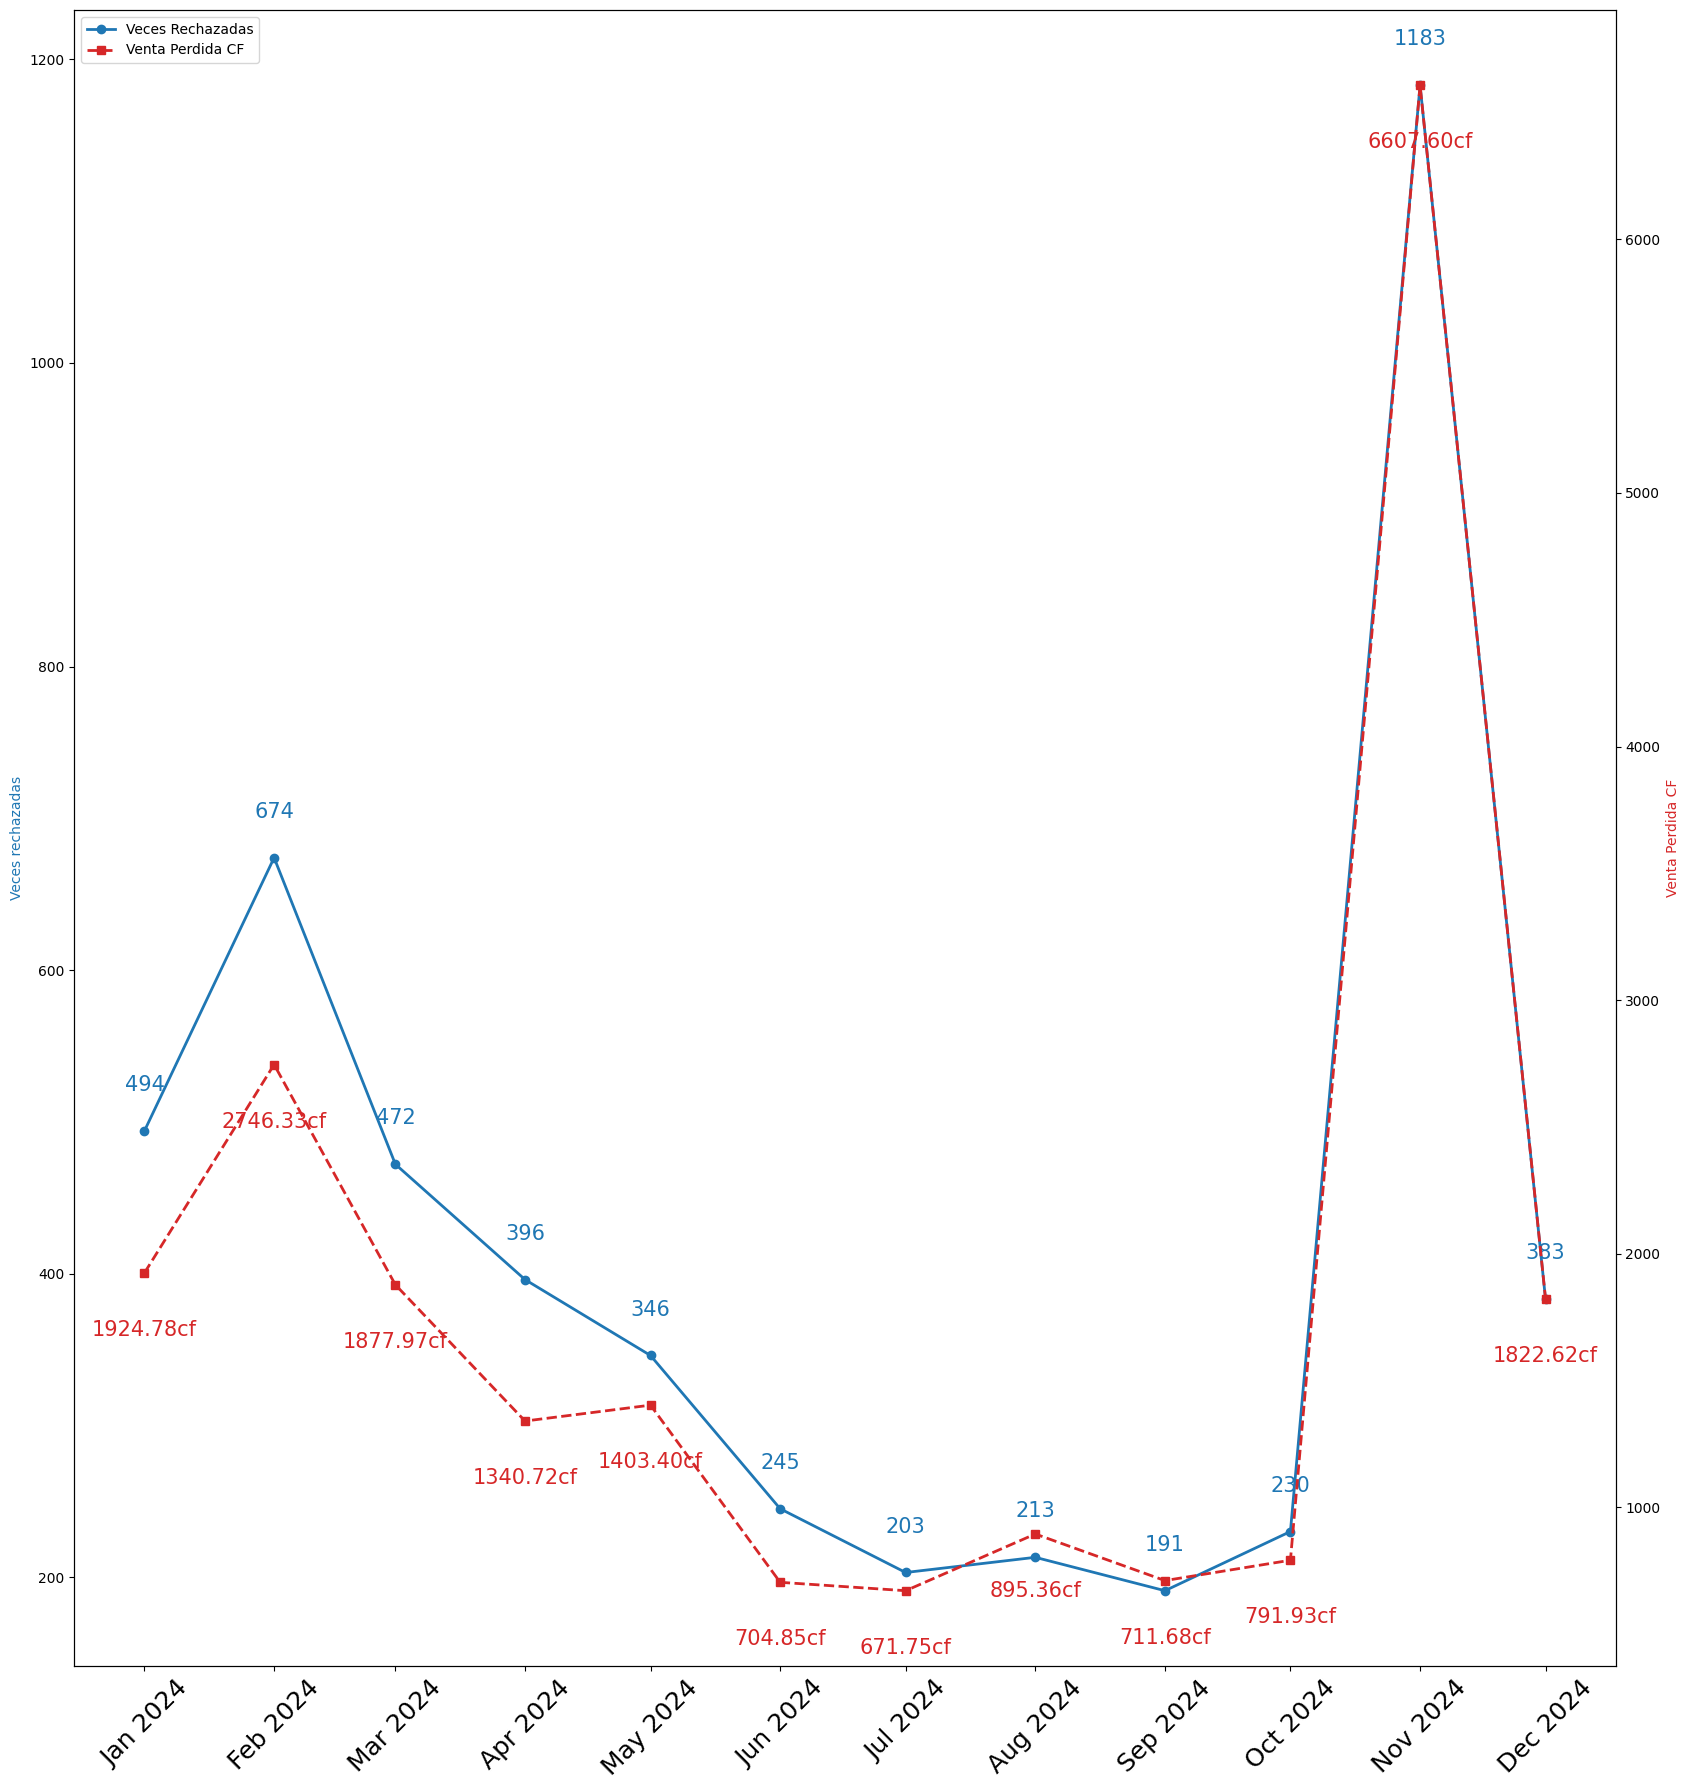

In [387]:
# Venta perdida y rechazos por Mes y Dia

def vr_vp_mes():
    try:
        # Suponiendo que 'ruta' tiene una columna 'Día' en formato datetime
        ruta['Mes'] = ruta['Día'].dt.to_period('M').dt.to_timestamp()

        # Tendencia por mes (adaptado desde día)
        vr_por_mes = (
            ruta.groupby("Mes")
                .size()
                .sort_index()
        )

        vp_por_mes = (
            ruta.groupby("Mes")["Venta Perdida CF"]
                .sum()
                .sort_index()
        )

        # Dibuja
        fig, ax1 = plt.subplots(figsize=(17, 18))

        # Eje primario: Veces rechazadas
        ax1.plot(vr_por_mes.index, vr_por_mes.values, marker="o", label="Veces Rechazadas", linewidth=2, color="tab:blue")
        for x, y in zip(vr_por_mes.index, vr_por_mes.values):
            ax1.text(
                x, y + vr_por_mes.max() * 0.02, # 2 % por encima
                f"{y}",
                ha="center",
                va="bottom", 
                fontsize=15,
                color="tab:blue"
            )
        ax1.set_ylabel("Veces rechazadas", color="tab:blue")
        ax1.tick_params(axis="x", rotation=45, labelsize=18)

        # Formatear el eje X para mostrar el nombre del mes
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator())

        # Eje secundario: Venta Perdida
        ax2 = ax1.twinx()
        ax2.plot(vp_por_mes.index, vp_por_mes.values, marker="s", linestyle="--", label="Venta Perdida CF", color="tab:red", linewidth=2)
        for x, y in zip(vp_por_mes.index, vp_por_mes.values):
            ax2.text(
                x, y - vp_por_mes.max() * 0.04, # 4 % por debajo
                f"{y:.2f}cf", 
                ha="center", 
                va="bottom", 
                fontsize=15,
                color="tab:red"
            )
        ax2.set_ylabel("Venta Perdida CF", color="tab:red")

        # Leyenda combinada
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

        plt.tight_layout()
        plt.savefig('vr_vp_tiempo.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

def vr_vp_dia():
    try:
        # Tendencia por fecha
        vr_por_fecha = (
            ruta.groupby("Día")
            .size()          # equivalente a value_counts pero mantiene el orden cronológico
            .sort_index()    # ¡clave!: ordena el índice (las fechas)
        )

        # Suma de Venta Perdida por día
        vp_por_fecha = (
            ruta.groupby("Día")["Venta Perdida CF"]
            .sum()
            .sort_index()
        )

        # Dibuja
        fig, ax1 = plt.subplots(figsize=(17, 18))

        # Extraer días del mes para eje X
        dias = vr_por_fecha.index
        x_pos = list(range(len(dias)))

        # Eje primario: Veces rechazadas
        ax1.plot(
            x_pos,
            vr_por_fecha.values,
            marker="o",
            label="Veces Rechazadas",
            linewidth=2
        )

        # Etiquetas para cada punto de Rechazos
        for x, y in zip(x_pos, vr_por_fecha.values):
            ax1.text(
                x, y + vr_por_fecha.max() * 0.02,  # 2 % por encima
                f"{y}",
                ha="center",
                va="bottom",
                fontsize=14,
                color="tab:blue"
            )

        # Eje secundario: Venta Perdida
        ax2 = ax1.twinx()
        ax2.plot(
            x_pos,
            vp_por_fecha.values,
            marker="s",
            linestyle="--",
            label="Venta Perdida CF",
            color="tab:red",
            linewidth=2
        )

        # Etiquetas para Venta Perdida
        for x, y in zip(x_pos, vp_por_fecha.values):
            ax2.text(
                x, y - vp_por_fecha.max() * 0.04,  # 4 % por debajo
                f"{y:.2f}cf",
                ha="center",
                va="bottom",
                fontsize=14,
                color="tab:red"
            )

        # Formato de los ejes
        ax1.set_ylabel("Veces rechazadas", color="tab:blue")
        ax2.set_ylabel("Venta Perdida CF", color="tab:red")
        
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([str(fecha.day) for fecha in dias], rotation=0, fontsize=18)

        # Leyendas y formato
        # Combinar leyendas de ambos ejes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

        plt.tight_layout()
        plt.savefig('vr_vp_tiempo.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

opcion_fecha_string = ""
if opcion_tiempo == 1:
    opcion_fecha_string = "mes"
    vr_vp_mes_titulo = f'Tiempo Histórico de Rechazos y Venta Perdida (CF) por mes del año {fecha}'
    vr_vp_mes_descripcion = 'Este gráfico muestra las veces rechazadas y ventas perdidas (CF) a travéz del tiempo (por mes).'
    vr_vp_mes()
if opcion_tiempo == 2:
    opcion_fecha_string = "dia"
    vr_vp_dia_titulo = f'Tiempo Histórico de Rechazos y Venta Perdida (CF) por día del mes {fecha}'
    vr_vp_dia_descripcion = 'Este gráfico muestra las veces rechazadas y ventas perdidas (CF) a travéz del tiempo (por día).'
    vr_vp_dia()

### MOTIVO DE ANULACION

In [388]:
# CONFIGURACION PERSONALIZADA

categoria_title = 'Motivo de Anulación'
categoria_descripcion = 'motivo de anulación'

In [389]:
# Venta perdida por motivo de anulación
#motivos_vp = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)
#motivos_vp.plot(kind='bar', title='Cantidad de venta perdida por motivo')

vp_motivo_anulacion_titulo = f'Venta Perdida (CF) por {categoria_title}'
vp_motivo_anulacion_descripcion = f'Este gráfico muestra la cantidad de venta perdida por {categoria_descripcion} de forma descendente.'
def vp_motivo_anulacion():
    try:
        # Agrupar y ordenar
        motivos_vp = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        bars = motivos_vp.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_1
        )

        total_vp_motivos = 0
        # Agregar valores exactos encima de cada barra
        for i, value in enumerate(motivos_vp.values):
            total_vp_motivos = total_vp_motivos + value
            ax.text(
                i, value + (value * 0.01),  # posición X, Y
                f'{value:,.1f}cf',          # formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico (opcional)
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_motivos, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('vp_motivo_anulacion.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [390]:
# Veces rechazadas por motivo de anulación
# ruta['Motivo de anulación'].value_counts().plot(kind='bar', title='Top motivos de anulación')

vr_motivo_anulacion_titulo = f'Veces Rechazadas por {categoria_title}'
vr_motivo_anulacion_descripcion = f'Este gráfico muestra la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_motivo_anulacion():
    try:
        # Obtener los datos
        motivos_counts = ruta['Motivo de anulación'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = motivos_counts.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_2
        )

        total_motivos = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(motivos_counts.values):
            total_motivos = total_motivos + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_motivos)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        # Mostrar gráfico
        plt.tight_layout()
        plt.savefig('vr_motivo_anulacion.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [391]:
# Venta perdida y rechazos por Motivo de anulacion

vp_vr_motivo_anulacion_titulo = f'Venta Perdida (CF) y Veces Rechazadas por {categoria_title}'
vp_vr_motivo_anulacion_descripcion = f'Este gráfico muestra la venta perdida y la cantidad de veces rechazadas por {categoria_descripcion}, ordenado de forma descendente.'
def vp_vr_motivo_anulacion():
    try:
        group = ruta.groupby('Motivo de anulación')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        motivos = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[motivos]
        cantidad = cantidad[motivos]

        # Preparar posiciones
        x = np.arange(len(motivos))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(bar_width, bar_height))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})', color=color_1)
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Veces Rechazadas (Total: {round(total_cm, 2)})', color=color_2)

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(motivos, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.1f}cf',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.savefig('vp_vr_motivo_anulacion.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [392]:
# Venta perdida porcentual por motivo de anulación

vp_porcentual_motivo_anulacion_titulo = f'Venta Perdida (CF %) por {categoria_title} en Porcentaje'
vp_porcentual_motivo_anulacion_descripcion = f'Este gráfico muestra la venta perdida en porcentaje por {categoria_descripcion} de forma descendente.'
def vp_porcentual_motivo_anulacion():
    try:
        # Agrupar y ordenar por venta perdida
        vp_motivo_anulacion = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los 10 principales motivos de anulacion si el analisis es anual
        # vp_motivo_anulacion = vp_motivo_anulacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_ma, circle_height_ma))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_motivo_anulacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los motivos de anulación
        ax.legend(
            wedges,
            vp_motivo_anulacion.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vp_porcentual_motivo_anulacion_titulo}')
        plt.tight_layout()
        plt.savefig('vp_porcentual_motivo_anulacion.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [393]:
# Veces rechazadas porcentual por motivo de anulación

vr_porcentual_motivo_anulacion_titulo = f'Veces Rechazadas (%) por {categoria_title}'
vr_porcentual_motivo_anulacion_descripcion = f'Este gráfico muestra el porcentaje de la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_porcentual_motivo_anulacion():
    try:
        # Obtener los datos
        vr_motivo_anulacion = ruta['Motivo de anulación'].value_counts()

        # (Opcional) Limitar a los 10 principales motivos de anulacion si el analisis es anual
        # vr_motivo_anulacion = vr_motivo_anulacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_ma, circle_height_ma))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_motivo_anulacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los motivos de anulación
        ax.legend(
            wedges,
            vr_motivo_anulacion.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vr_porcentual_motivo_anulacion_titulo}')
        plt.tight_layout()
        plt.savefig('vr_porcentual_motivo_anulacion.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### TRANSPORTISTA

In [394]:
# CONFIGURACION PERSONALIZADA

categoria_title = 'Transportista'
categoria_descripcion = 'transportista'

In [395]:
# Venta perdida por transportista
# ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False).plot(kind='bar', title='Venta Perdida por Transportista')

vp_transportista_titulo = f'Venta Perdida (CF) por {categoria_title}'
vp_transportista_descripcion = f'Este gráfico muestra la cantidad de venta perdida por {categoria_descripcion} de forma descendente.'
def vp_transportista():
    try:
        # Agrupar y ordenar
        vp_transportista = ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vp_transportista.plot(
            kind='bar',
            title=f'{vp_transportista_titulo}',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_1
        )

        total_vp_transportista = 0
        # Agregar valores exactos encima de cada barra
        for i, value in enumerate(vp_transportista.values):
            total_vp_transportista = total_vp_transportista + value
            ax.text(
                i, value + (value * 0.01),       # posición Y: ligeramente arriba de la barra
                f'{value:,.1f}cf',                # formato: separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico (opcional)
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_transportista, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('vp_transportista.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [396]:
# Veces rechazadas por transportista

vr_transportista_titulo = f'Veces Rechazadas por {categoria_title}'
vr_transportista_descripcion = f'Este gráfico muestra la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_transportista():
    try:
        # Obtener los datos
        transportista_counts = ruta['Transportista'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = transportista_counts.plot(
            kind='bar',
            title=f'{vr_transportista_titulo}',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_2
        )

        total_transportista = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(transportista_counts.values):
            total_transportista = total_transportista + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_transportista)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        # Mostrar gráfico
        plt.tight_layout()
        plt.savefig('vr_transportista.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [397]:
# Venta perdida y rechazos por Transportista

vp_vr_transportista_titulo = f'Venta Perdida (CF) y Veces Rechazadas por {categoria_title}'
vp_vr_transportista_descripcion = f'Este gráfico muestra la venta perdida y la cantidad de veces rechazadas por {categoria_descripcion}, ordenado de forma descendente.'
def vp_vr_transportista():
    try:
        group = ruta.groupby('Transportista')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        transportistas = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[transportistas]
        cantidad = cantidad[transportistas]

        # Preparar posiciones
        x = np.arange(len(transportistas))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(bar_width, bar_height))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})', color=color_1)
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Veces Rechazadas (Total: {round(total_cm, 2)})', color=color_2)

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(transportistas, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.1f}cf',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.savefig('vp_vr_transportista.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [398]:
# Venta perdida porcentual por transportista

vp_porcentual_transportista_titulo = f'Venta Perdida (CF %) por {categoria_title} en Porcentaje'
vp_porcentual_transportista_descripcion = f'Este gráfico muestra la venta perdida en porcentaje por {categoria_descripcion} de forma descendente.'
def vp_porcentual_transportista():
    try:
        # Agrupar y ordenar por venta perdida
        vp_transportista = ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los 10 principales transportistas si el analisis es anual
        # vp_transportista = vp_transportista.head(12)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_width_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_transportista,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los transportistas
        ax.legend(
            wedges,
            vp_transportista.index,
            title=f'{categoria_title}',
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vp_porcentual_transportista_titulo}')
        plt.tight_layout()
        plt.savefig('vp_porcentual_transportista.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [399]:
# Veces rechazadas porcentual por transportista

vr_porcentual_transportista_titulo = f'Veces Rechazadas (%) por {categoria_title}'
vr_porcentual_transportista_descripcion = f'Este gráfico muestra el porcentaje de la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_porcentual_transportista():
    try:
        # Obtener los datos
        vr_transportista = ruta['Transportista'].value_counts()

        # (Opcional) Limitar a los principales transportista si el analisis es anual o mensual
        # vr_transportista = vr_transportista.head(12)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(16, 11))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_transportista,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los transportistas
        ax.legend(
            wedges,
            vr_transportista.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vr_porcentual_transportista_titulo}')
        plt.tight_layout()
        plt.savefig('vr_porcentual_transportista.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### RUTA TRONCAL

In [400]:
# CONFIGURACION PERSONALIZADA

categoria_title = 'Ruta'
categoria_descripcion = 'ruta'

In [401]:
# Venta perdida por ruta
# ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False).plot(kind='bar', title='Venta Perdida por Ruta')

vp_ruta_titulo = f'Venta Perdida (CF) por {categoria_title}'
vp_ruta_descripcion = f'Este gráfico muestra la cantidad de venta perdida por {categoria_descripcion} de forma descendente.'
def vp_ruta():
    try:
        # Agrupar y ordenar por venta perdida
        vp_ruta = ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vp_ruta.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_1
        )

        total_vp_ruta = 0
        # Agregar etiquetas con valores exactos
        for i, value in enumerate(vp_ruta.values):
            total_vp_ruta = total_vp_ruta + value
            ax.text(
                i, value + (value * 0.01), # Y: un poco arriba de la barra
                f'{value:,.1f}cf',          # formato con separadores de miles
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_ruta, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=0, ha='right')

        plt.tight_layout()
        plt.savefig('vp_ruta.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [402]:
# Veces rechazadas por ruta

vr_ruta_titulo = f'Veces Rechazadas por {categoria_title}'
vr_ruta_descripcion = f'Este gráfico muestra la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_ruta():
    try:
        # Obtener los datos
        ruta_counts = ruta['Ruta Troncal Dinámico'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = ruta_counts.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_2
        )

        total_ruta = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(ruta_counts.values):
            total_ruta = total_ruta + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_ruta)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=0, ha='right')

        # Mostrar gráfico
        plt.tight_layout()
        plt.savefig('vr_ruta.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [403]:
# Venta perdida y rechazos por Ruta

vp_vr_ruta_titulo = f'Venta Perdida (CF) y Veces Rechazadas por {categoria_title}'
vp_vr_ruta_descripcion = f'Este gráfico muestra la venta perdida y la cantidad de veces rechazadas por {categoria_descripcion}, ordenado de forma descendente.'
def vp_vr_ruta():
    try:
        group = ruta.groupby('Ruta Troncal Dinámico')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        rutas = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[rutas]
        cantidad = cantidad[rutas]

        # Preparar posiciones
        x = np.arange(len(rutas))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(bar_width, bar_height))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})', color=color_1)
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Veces Rechazadas (Total: {round(total_cm, 2)})', color=color_2)

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(rutas, rotation=0, ha='right')
        ax.set_ylabel('Valores')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.1f}cf',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.savefig('vp_vr_ruta.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [404]:
# Venta perdida porcentual por ruta

vp_porcentual_ruta_titulo = f'Venta Perdida (CF %) por {categoria_title} en Porcentaje'
vp_porcentual_ruta_descripcion = f'Este gráfico muestra la venta perdida en porcentaje por {categoria_descripcion} de forma descendente.'
def vp_porcentual_ruta():
    try:
        # Agrupar y ordenar por venta perdida
        vp_ruta = ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a las principales rutas si el analisis es anual
        # vp_ruta = vp_ruta.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_ma, circle_height_ma))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_ruta,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de las rutas
        ax.legend(
            wedges,
            vp_ruta.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vp_porcentual_ruta_titulo}')
        plt.tight_layout()
        plt.savefig('vp_porcentual_ruta.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [405]:
# Veces rechazadas porcentual por ruta

vr_porcentual_ruta_titulo = f'Veces Rechazadas (%) por {categoria_title}'
vr_porcentual_ruta_descripcion = f'Este gráfico muestra el porcentaje de la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_porcentual_ruta():
    try:
        # Obtener los datos
        vr_ruta = ruta['Ruta Troncal Dinámico'].value_counts()

        # (Opcional) Limitar a las principales rutas si el analisis es anual
        # vr_ruta = vr_ruta.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_ma, circle_height_ma))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_ruta,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de las rutas
        ax.legend(
            wedges,
            vr_ruta.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vr_porcentual_ruta_titulo}')
        plt.tight_layout()
        plt.savefig('vr_porcentual_ruta.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### CLIENTE

In [406]:
# CONFIGURACION PERSONALIZADA

categoria_title = 'Cliente'
categoria_descripcion = 'cliente'

In [407]:
# Venta perdida por cliente
# clientes_vp = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)
# clientes_vp.plot(kind='bar', title='Venta Perdida por Cliente')

vp_cliente_titulo = f'Venta Perdida (CF) por {categoria_title}'
vp_cliente_descripcion = f'Este gráfico muestra la cantidad de venta perdida por {categoria_descripcion} de forma descendente.'
def vp_cliente():
    try:
        # Agrupar y ordenar por venta perdida
        clientes_vp = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los principales clientes si el analisis es anual
        clientes_vp = clientes_vp.head(12) if opcion_tiempo == 1 else clientes_vp.head(20)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        clientes_vp.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_1
        )

        total_vp_cliente = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(clientes_vp.values):
            total_vp_cliente = total_vp_cliente + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.1f}cf',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_cliente, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('vp_cliente.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [408]:
# Veces rechazadas por cliente

vr_cliente_titulo = f'Veces Rechazadas por {categoria_title}'
vr_cliente_descripcion = f'Este gráfico muestra la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_cliente():
    try:
        # Obtener los datos
        cliente_counts = ruta['Cliente'].value_counts()

        # (Opcional) Limitar a los principales clientes si el analisis es anual
        cliente_counts = cliente_counts.head(12) if opcion_tiempo == 1 else cliente_counts.head(20)

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = cliente_counts.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_2
        )

        total_cliente = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(cliente_counts.values):
            total_cliente = total_cliente + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_cliente)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        # Mostrar gráfico
        plt.tight_layout()
        plt.savefig('vr_cliente.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [409]:
# Venta perdida y rechazos por Cliente

vp_vr_cliente_titulo = f'Venta Perdida (CF) y Veces Rechazadas por {categoria_title}'
vp_vr_cliente_descripcion = f'Este gráfico muestra la venta perdida y la cantidad de veces rechazadas por {categoria_descripcion}, ordenado de forma descendente.'
def vp_vr_cliente():
    try:
        group = ruta.groupby('Cliente')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        # cliente = venta_perdida.sort_values(ascending=False).index
        # venta_perdida = venta_perdida[cliente]
        # cantidad = cantidad[cliente]
        venta_perdida = venta_perdida.sort_values(ascending=False).head(12) if opcion_tiempo == 1 else venta_perdida.sort_values(ascending=False).head(20)
        cantidad = cantidad[venta_perdida.index]
        cliente = venta_perdida.index

        # Preparar posiciones
        x = np.arange(len(cliente))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(bar_width, bar_height))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})', color=color_1)
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Veces Rechazadas (Total: {round(total_cm, 2)})', color=color_2)

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(cliente, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.1f}cf',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.savefig('vp_vr_cliente.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [410]:
# Venta perdida porcentual por cliente

vp_porcentual_cliente_titulo = f'Venta Perdida (CF %) por {categoria_title} en Porcentaje'
vp_porcentual_cliente_descripcion = f'Este gráfico muestra la venta perdida en porcentaje por {categoria_descripcion} de forma descendente.'
def vp_porcentual_cliente():
    try:
        # Agrupar y ordenar por venta perdida
        vp_cliente = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los principales clientes si el analisis es anual
        vp_cliente = vp_cliente.head(12) if opcion_tiempo == 1 else vp_cliente.head(20)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_height_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_cliente,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vp_cliente.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vp_porcentual_cliente_titulo}')
        plt.tight_layout()
        plt.savefig('vp_porcentual_cliente.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [411]:
# Veces rechazadas porcentual por cliente

vr_porcentual_cliente_titulo = f'Veces Rechazadas (%) por {categoria_title}'
vr_porcentual_cliente_descripcion = f'Este gráfico muestra el porcentaje de la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_porcentual_cliente():
    try:
        # Obtener los datos
        vr_cliente = ruta['Cliente'].value_counts()

        # (Opcional) Limitar a los principales clientes si el analisis es anual
        vr_cliente = vr_cliente.head(12) if opcion_tiempo == 1 else vr_cliente.head(20)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_height_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_cliente,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vr_cliente.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vr_porcentual_cliente_titulo}')
        plt.tight_layout()
        plt.savefig('vr_porcentual_cliente.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### VENDEDOR

In [412]:
# CONFIGURACION PERSONALIZADA

categoria_title = 'Vendedor'
categoria_descripcion = 'vendedor'

In [413]:
# Venta perdida por vendedor

vp_vendedor_titulo = f'Venta Perdida (CF) por {categoria_title}'
vp_vendedor_descripcion = f'Este gráfico muestra la cantidad de venta perdida por {categoria_descripcion} de forma descendente.'
def vp_vendedor():
    try:
        # Agrupar y ordenar por venta perdida
        vendedor_vp = ruta.groupby('Nombre Vendedor')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los principales clientes si el analisis es anual
        vendedor_vp = vendedor_vp.head(12) if opcion_tiempo == 1 else vendedor_vp.head(20)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vendedor_vp.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_1
        )

        total_vp_vendedor = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(vendedor_vp.values):
            total_vp_vendedor = total_vp_vendedor + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.1f}cf',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_vendedor, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('vp_vendedor.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [414]:
# Veces rechazadas por vendedor

vr_vendedor_titulo = f'Veces Rechazadas por {categoria_title}'
vr_vendedor_descripcion = f'Este gráfico muestra la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_vendedor():
    try:
        # Obtener los datos
        vendedor_counts = ruta['Nombre Vendedor'].value_counts()

        # (Opcional) Limitar a los principales clientes si el analisis es anual
        vendedor_counts = vendedor_counts.head(12) if opcion_tiempo == 1 else vendedor_counts.head(20)

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = vendedor_counts.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_2
        )

        total_vendedor = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(vendedor_counts.values):
            total_vendedor = total_vendedor + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_vendedor)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        # Mostrar gráfico
        plt.tight_layout()
        plt.savefig('vr_vendedor.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [415]:
# Venta perdida y rechazos por Vendedor

vp_vr_vendedor_titulo = f'Venta Perdida (CF) y Veces Rechazadas por {categoria_title}'
vp_vr_vendedor_descripcion = f'Este gráfico muestra la venta perdida y la cantidad de veces rechazadas por {categoria_descripcion}, ordenado de forma descendente.'
def vp_vr_vendedor():
    try:
        group = ruta.groupby('Nombre Vendedor')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        # vendedor = venta_perdida.sort_values(ascending=False).index
        # venta_perdida = venta_perdida[vendedor]
        # cantidad = cantidad[vendedor]
        venta_perdida = venta_perdida.sort_values(ascending=False).head(12) if opcion_tiempo == 1 else venta_perdida.sort_values(ascending=False).head(20)
        cantidad = cantidad[venta_perdida.index]
        vendedor = venta_perdida.index

        # Preparar posiciones
        x = np.arange(len(vendedor))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(bar_width, bar_height))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})', color=color_1)
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Veces Rechazadas (Total: {round(total_cm, 2)})', color=color_2)

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(vendedor, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.1f}cf',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.savefig('vp_vr_vendedor.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [416]:
# Venta perdida porcentual por vendedor

vp_porcentual_vendedor_titulo = f'Venta Perdida (CF %) por {categoria_title} en Porcentaje'
vp_porcentual_vendedor_descripcion = f'Este gráfico muestra la venta perdida en porcentaje por {categoria_descripcion} de forma descendente.'
def vp_porcentual_vendedor():
    try:
        # Agrupar y ordenar por venta perdida
        vp_vendedor = ruta.groupby('Nombre Vendedor')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los principales vendedores si el analisis es anual
        vp_vendedor = vp_vendedor.head(12) if opcion_tiempo == 1 else vp_vendedor.head(20)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_height_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_vendedor,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los vendedores
        ax.legend(
            wedges,
            vp_vendedor.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vp_porcentual_vendedor_titulo}')
        plt.tight_layout()
        plt.savefig('vp_porcentual_vendedor.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [417]:
# Veces rechazadas porcentual por vendedor

vr_porcentual_vendedor_titulo = f'Veces Rechazadas (%) por {categoria_title}'
vr_porcentual_vendedor_descripcion = f'Este gráfico muestra el porcentaje de la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_porcentual_vendedor():
    try:
        # Obtener los datos
        vr_vendedor = ruta['Nombre Vendedor'].value_counts()

        # (Opcional) Limitar a los principales vendedores si el analisis es anual
        vr_vendedor = vr_vendedor.head(12) if opcion_tiempo == 1 else vr_vendedor.head(20)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_height_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_vendedor,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vr_vendedor.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vr_porcentual_vendedor_titulo}')
        plt.tight_layout()
        plt.savefig('vr_porcentual_vendedor.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### LOCACION

In [418]:
# CONFIGURACION PERSONALIZADA

categoria_title = 'Locacion'
categoria_descripcion = 'locacion'

In [419]:
# Venta perdida por Locacion

vp_locacion_titulo = f'Venta Perdida (CF) por {categoria_title}'
vp_locacion_descripcion = f'Este gráfico muestra la cantidad de venta perdida por {categoria_descripcion} de forma descendente.'
def vp_locacion():
    try:
        # Agrupar y ordenar por venta perdida
        locacion_vp = ruta.groupby('Locación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        locacion_vp.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_1
        )

        total_vp_locacion = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(locacion_vp.values):
            total_vp_locacion = total_vp_locacion + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.1f}cf',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_locacion, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('vp_locacion.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [420]:
# Veces rechazadas por locacion

vr_locacion_titulo = f'Veces Rechazadas por {categoria_title}'
vr_locacion_descripcion = f'Este gráfico muestra la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_locacion():
    try:
        # Obtener los datos
        locacion_counts = ruta['Locación'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = locacion_counts.plot(
            kind='bar',
            ax=ax,
            figsize=(bar_width, bar_height),
            color=color_2
        )

        total_locacion = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(locacion_counts.values):
            total_locacion = total_locacion + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_locacion)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        # Cambiar el titulo del eje x
        ax.set_xlabel("")

        # Rotar etiquetas del eje X
        plt.xticks(rotation=45, ha='right')

        # Mostrar gráfico
        plt.tight_layout()
        plt.savefig('vr_locacion.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [421]:
# Venta perdida y rechazos por Locacion

vp_vr_locacion_titulo = f'Venta Perdida (CF) y Veces Rechazadas por {categoria_title}'
vp_vr_locacion_descripcion = f'Este gráfico muestra la venta perdida y la cantidad de veces rechazadas por {categoria_descripcion}, ordenado de forma descendente.'
def vp_vr_locacion():
    try:
        group = ruta.groupby('Locación')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        locacion = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[locacion]
        cantidad = cantidad[locacion]

        # Preparar posiciones
        x = np.arange(len(locacion))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(bar_width, bar_height))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})', color=color_1)
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Veces Rechazadas (Total: {round(total_cm, 2)})', color=color_2)

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(locacion, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.1f}cf',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.savefig('vp_vr_locacion.png')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [422]:
# Venta perdida porcentual por locacion

vp_porcentual_locacion_titulo = f'Venta Perdida (CF %) por {categoria_title} en Porcentaje'
vp_porcentual_locacion_descripcion = f'Este gráfico muestra la venta perdida en porcentaje por {categoria_descripcion} de forma descendente.'
def vp_porcentual_locacion():
    try:
        # Agrupar y ordenar por venta perdida
        vp_locacion = ruta.groupby('Locación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a las 10 principales locaciones si el analisis es anual
        # vp_locacion = vp_locacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_height_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_locacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de las locaciones
        ax.legend(
            wedges,
            vp_locacion.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vp_porcentual_locacion_titulo}')
        plt.tight_layout()
        plt.savefig('vp_porcentual_locacion.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [423]:
# Veces rechazadas porcentual por locacion

vr_porcentual_locacion_titulo = f'Veces Rechazadas (%) por {categoria_title}'
vr_porcentual_locacion_descripcion = f'Este gráfico muestra el porcentaje de la cantidad de veces que hubo rechazo por {categoria_descripcion}, ordenado de forma descendente.'
def vr_porcentual_locacion():
    try:
        # Obtener los datos
        vr_locacion = ruta['Locación'].value_counts()

        # (Opcional) Limitar a las 10 principales locaciones si el analisis es anual
        # vr_locacion = vr_locacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(circle_width_tr, circle_height_tr))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_locacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': circle_text_size} # Tamaño de texto
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vr_locacion.index,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.05), # Posicion de la leyenda sobre el grafico
            fontsize=circle_legend_text_size,
            title_fontsize=circle_legend_title_size,
            ncol=circle_legend_nro_columns # Numero de columnas
        )

        # Título y estilo
        ax.set_title(f'{vr_porcentual_locacion_titulo}')
        plt.tight_layout()
        plt.savefig('vr_porcentual_locacion.png', bbox_inches='tight')
        #plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

# ANALISIS
### Consignar tipo de analisis (metrica o categoria)

CONFIGURACION --------------------------------------------------------------------------
Tiempo: Por Año -> 2024
Locaciones: ['06 AYA EL PEDREGAL', '38 AYA ATICO', '40 AYA CHALA', '88 AYA CAMANA']
Tipo de analisis: Métrica
Analisis: Por Veces Rechazadas


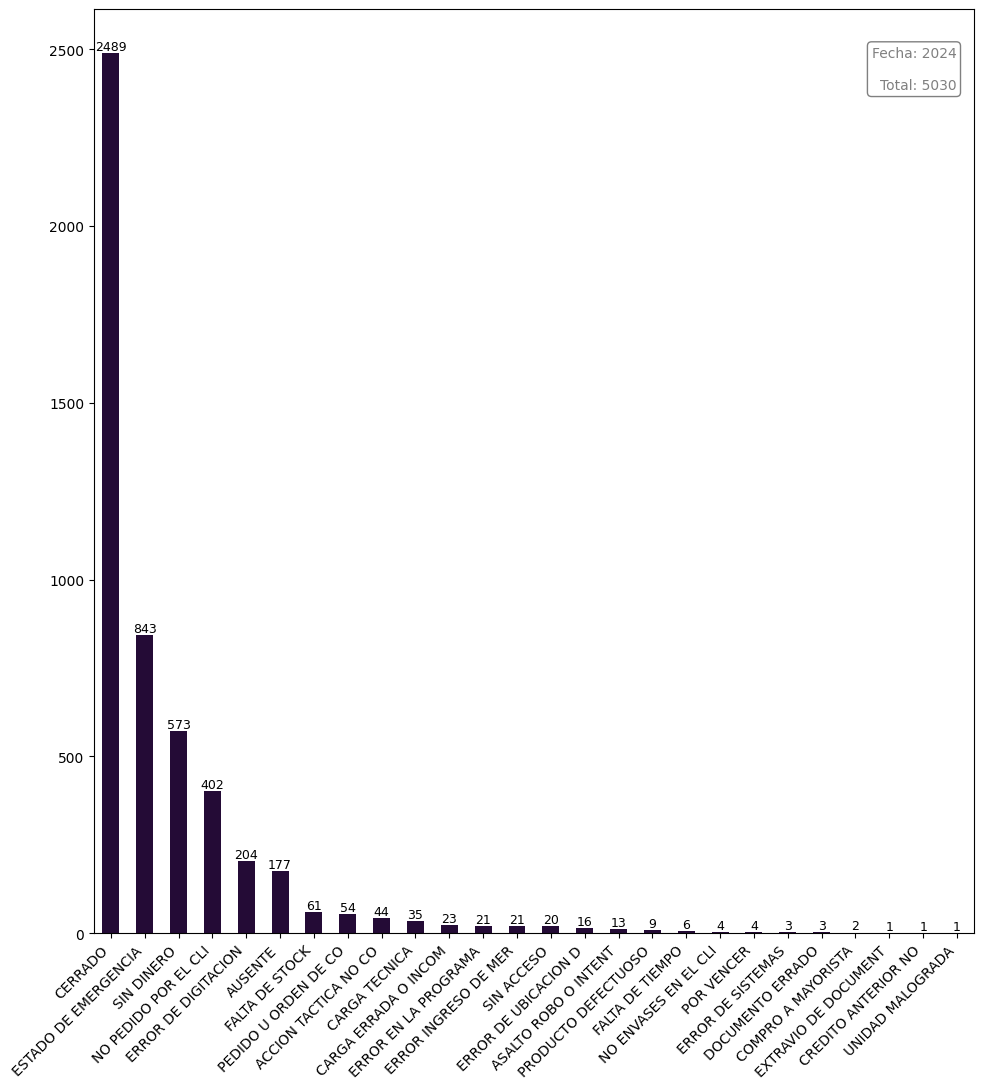

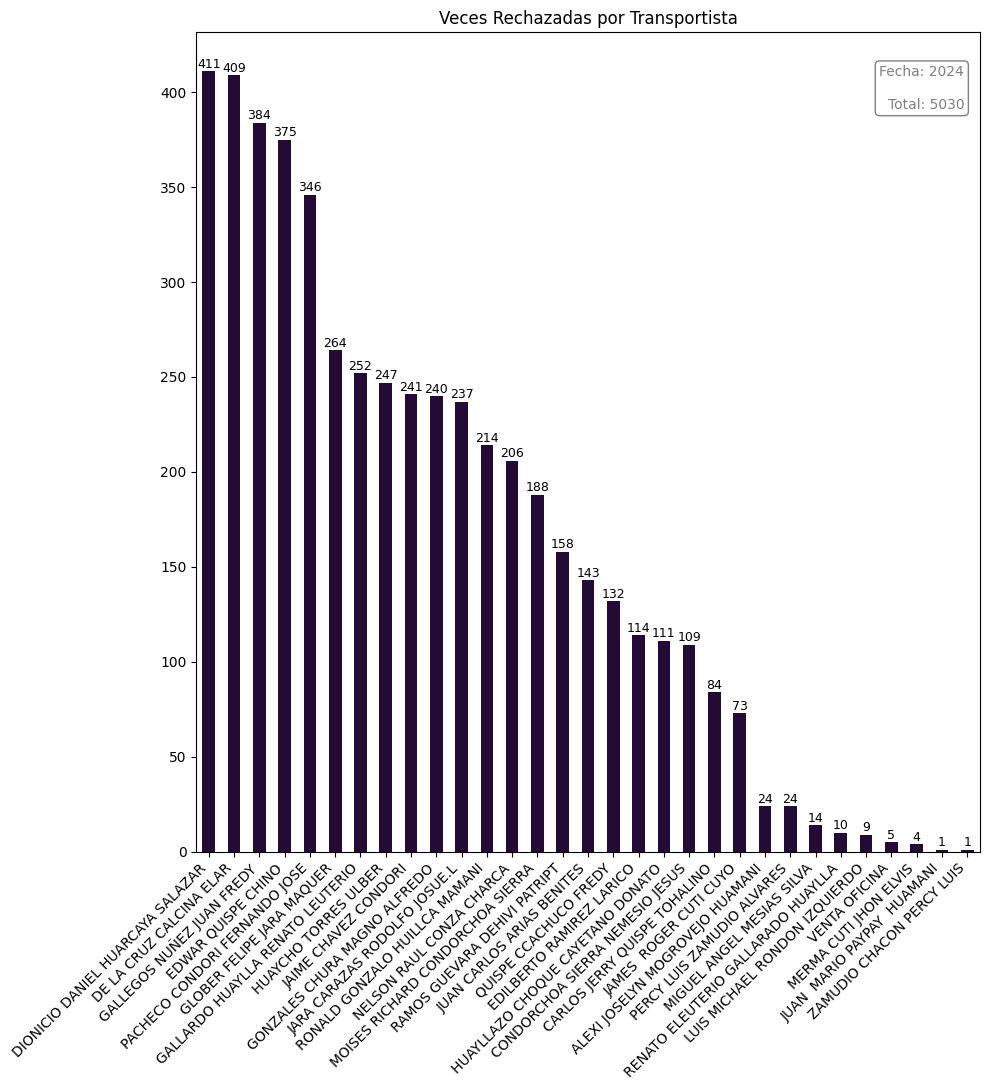

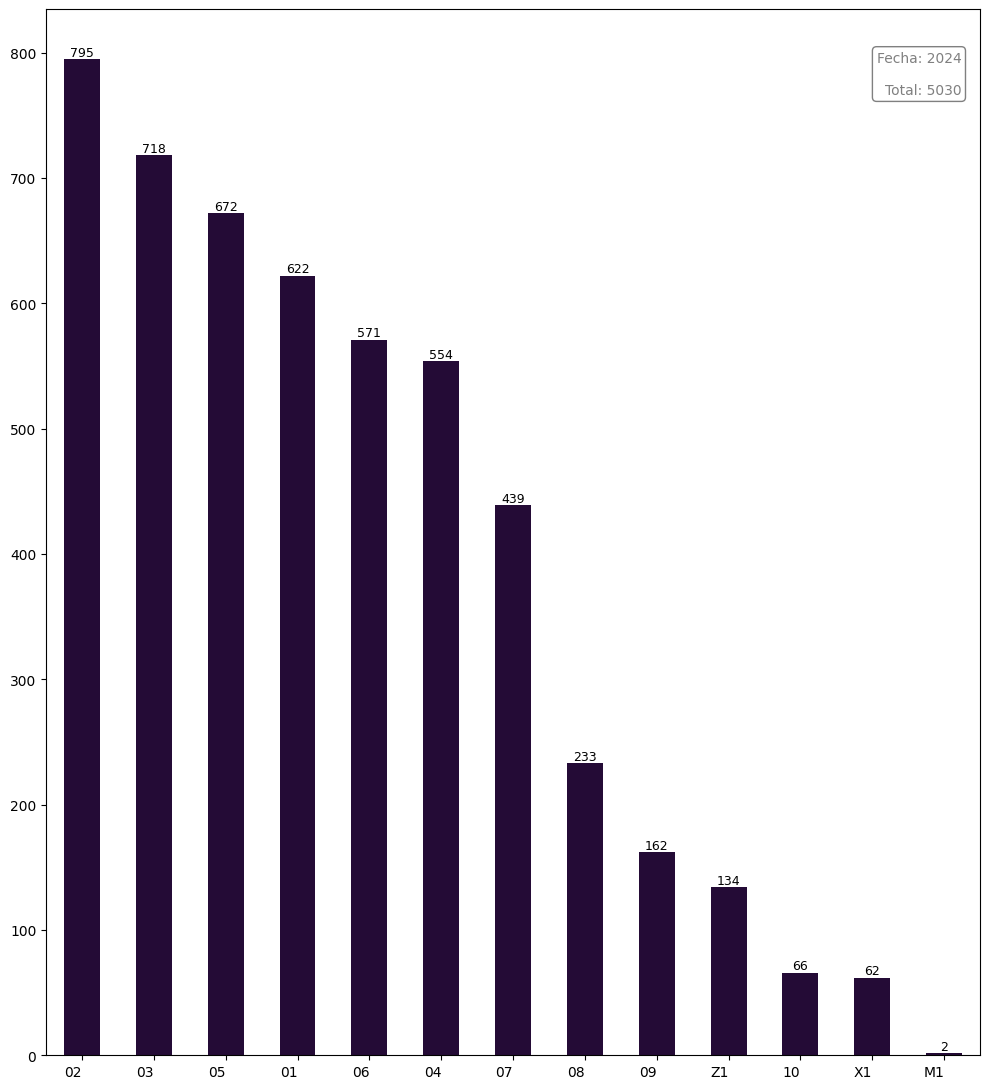

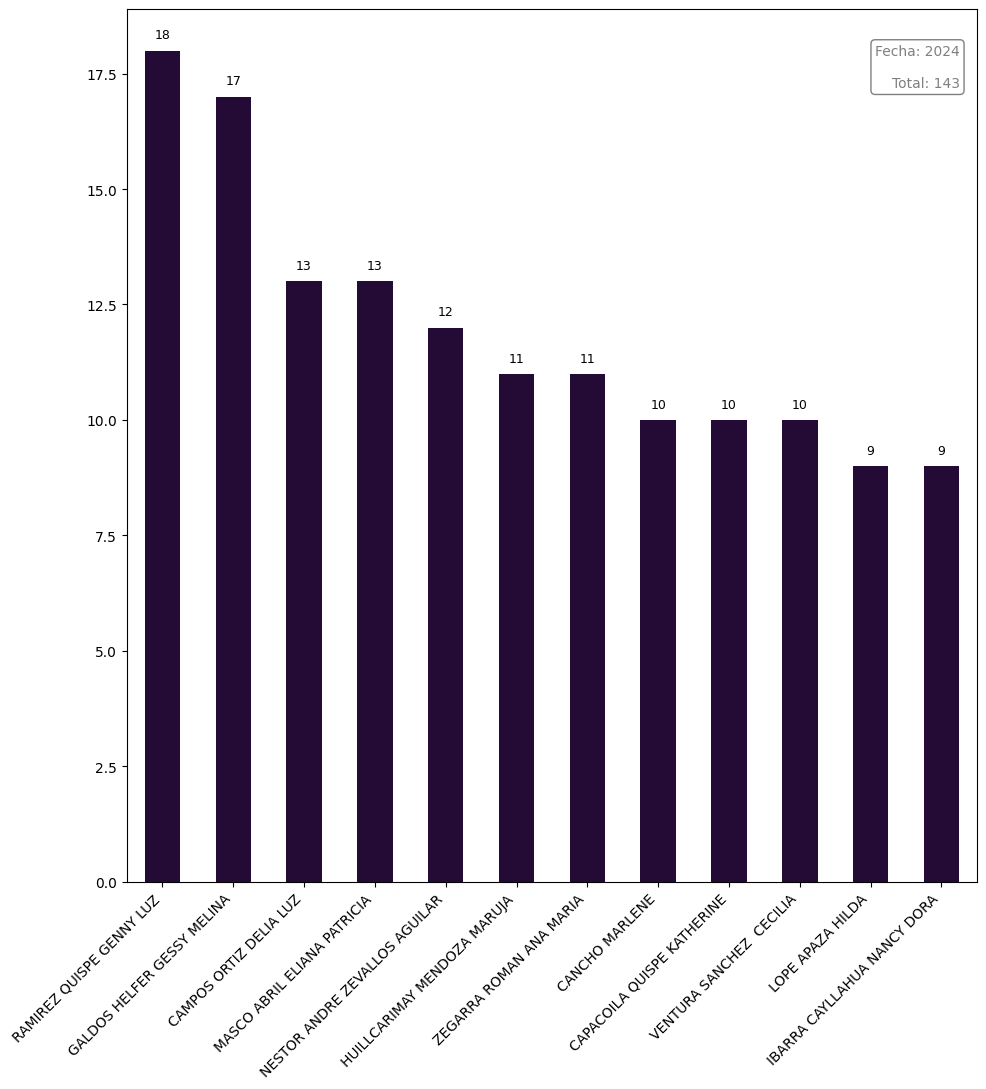

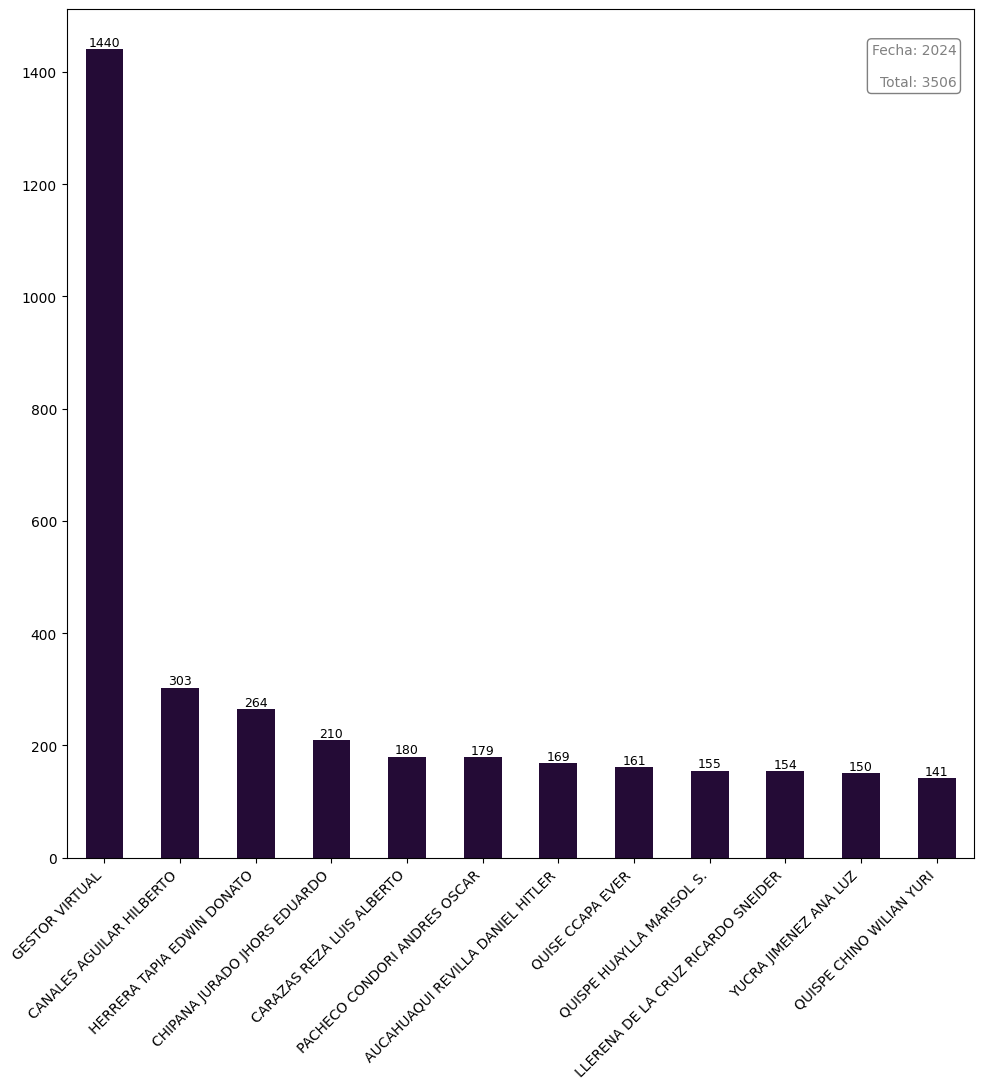

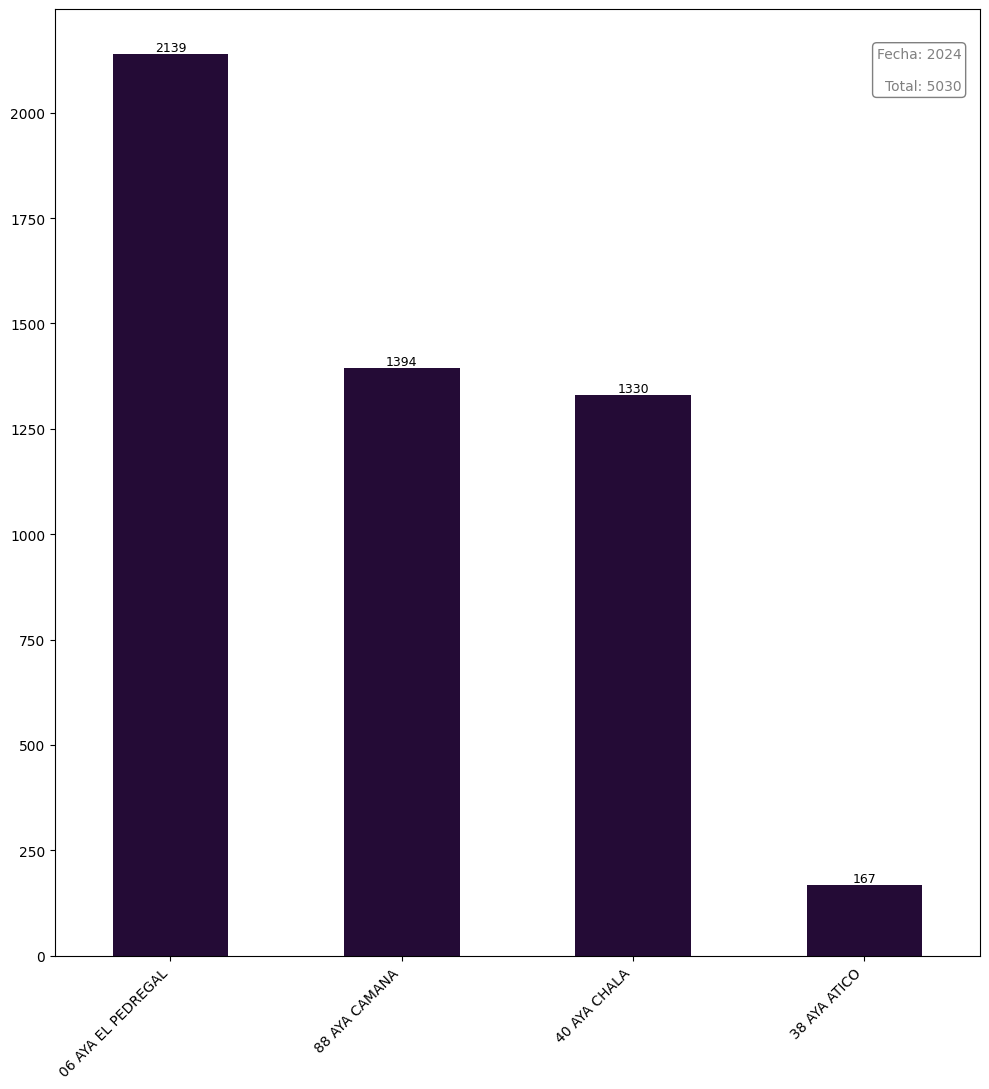

In [424]:
''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por Venta Perdida CF
(2) Por Veces Rechazadas
(3) Por Venta Perdida CF y Veces Rechazadas
(4) Por Venta Perdida (Porcentual)
(5) Por Veces Rechazadas (Porcentual)
(6) Por Categoria
'''

opcion_tiempo_dic = {
    1: 'Por Año',
    2: 'Por Mes',
    3: 'Por Día',
    4: 'Intervalo',
    5: 'Mayor igual que',
}

opcion_metrica_dic = {
    1: ['vp_', 'Por Venta Perdida CF'],
    2: ['vr_', 'Por Veces Rechazadas'],
    3: ['vp_vr_', 'Por Venta Perdida y Veces Rechazadas'],
    4: ['vp_porcentual_', 'Por Venta Perdida (Porcentual)'],
    5: ['vr_porcentual_', 'Por Veces Rechazadas (Porcentual)'],
}

opcion_categoria_dic = {
    1: ['motivo_anulacion', 'Por Motivo de Anulacion'],
    2: ['transportista', 'Por Transportista'],
    3: ['ruta', 'Por Ruta'],
    4: ['cliente', 'Por Cliente'],
    5: ['vendedor', 'Por Vendedor'],
    6: ['locacion', 'Por Locacion'],
}

# Seleccionar la opcion_tipo de análisis por tipo de analisis
opcion_tipo = int(input("(1=Metrica) (2=Categoria)"))

if opcion_tipo == 1: # Por metrica
    opcion_metrica = int(input("(1=VP) (2=VR) (3=VPyVR) (4=VP%) (5=VR%)"))
    eval(f'{opcion_metrica_dic[opcion_metrica][0]}motivo_anulacion()')
    eval(f'{opcion_metrica_dic[opcion_metrica][0]}transportista()')
    eval(f'{opcion_metrica_dic[opcion_metrica][0]}ruta()')
    eval(f'{opcion_metrica_dic[opcion_metrica][0]}cliente()')
    eval(f'{opcion_metrica_dic[opcion_metrica][0]}vendedor()')
    eval(f'{opcion_metrica_dic[opcion_metrica][0]}locacion()')

elif opcion_tipo == 2: # Por categoria
    opcion_categoria = int(input("(1=Motivo) (2=Transportista) (3=Ruta) (4=Cliente) (5=Vendedor) (6=Locacion)"))
    eval(f'vp_{opcion_categoria_dic[opcion_categoria][0]}()')
    eval(f'vr_{opcion_categoria_dic[opcion_categoria][0]}()')
    eval(f'vp_vr_{opcion_categoria_dic[opcion_categoria][0]}()')
    eval(f'vp_porcentual_{opcion_categoria_dic[opcion_categoria][0]}()')
    eval(f'vr_porcentual_{opcion_categoria_dic[opcion_categoria][0]}()')

print('CONFIGURACION --------------------------------------------------------------------------')


print(f'Tiempo: {opcion_tiempo_dic[opcion_tiempo]} -> {fecha}')
print(f'Locaciones: {locaciones}')
print(f'Tipo de analisis: {'Métrica' if opcion_tipo == 1 else 'Categoría'}')
print(f'Analisis: {opcion_metrica_dic[opcion_metrica][1] if opcion_tipo == 1 else opcion_categoria_dic[opcion_categoria][1]}')

# REPORTE

### SETUP

In [425]:
from docx import Document
from docx.shared import Inches, Pt, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn
from docx.oxml import OxmlElement
from itertools import zip_longest

# Crear documento
doc = Document()

### CONFIGURACION

In [426]:
# Definir variables o constantes de reporte

nombre_autor = 'Gerardo Portocarrero Banda'
correo_autor = 'ainformacion@ayacda.com'
page_width = 5.85

# Constantes
metrica = 'Métrica'
categoria = 'Categoría'
reporte = 'Reporte'

# Fuente de letra
letra_robotica = 'Courier New'
letra_formal = 'Segoe UI'

# Tamaño de letra
titulo_principal_size = 26
titulo_secundario_size = 16
subtitulo_size = 12
texto_normal_size = 9
notas_size = 7

# Colores
azul_profesional = "#365F91" # para titulos o subtitulos
azul_profesional_rgb = RGBColor(54, 95, 145) 
azul_corporativo = "#0066cc" # para subtitulos
azul_corporativo_rgb = RGBColor(0, 102, 204)
negro_total = "#000000" # para texto
negro_total_rgb = RGBColor(0, 0, 0)

### ENCABEZADO

In [427]:
# Encabezado de la primera sección
section = doc.sections[0]
header = section.header
header_paragraph = header.paragraphs[0]
header_paragraph.clear()

# Crear tabla en el encabezado: Nombre (izquierda) - Fecha (derecha) ===
table = header.add_table(rows=2, cols=2, width=Inches(page_width))
table.autofit = False
table.columns[0].width = Inches(4.3)
table.columns[1].width = Inches(1.5)

# Fila 1: Nombre y Fecha
cell_name = table.cell(0, 0)
cell_date = table.cell(0, 1)

p_name = cell_name.paragraphs[0]
p_name.paragraph_format.space_after = Pt(0)
run_name = p_name.add_run("Gerardo Portocarrero Banda")
run_name.font.name = letra_robotica
run_name.font.size = Pt(texto_normal_size)

p_date = cell_date.paragraphs[0]
p_date.paragraph_format.space_after = Pt(0)
p_date.alignment = WD_ALIGN_PARAGRAPH.RIGHT
hoy_hora_min_sec = datetime.now().replace(microsecond=0)
run_date = p_date.add_run(str(hoy_hora_min_sec))
run_date.font.name = letra_robotica
run_date.font.size = Pt(texto_normal_size)

# Fila 2: Subtítulo debajo de nombre (deja vacío la celda derecha)
cell_subtitle = table.cell(1, 0)
cell_subtitle_right = table.cell(1, 1)

p_sub = cell_subtitle.paragraphs[0]
p_sub.paragraph_format.space_before = Pt(0)
p_sub.paragraph_format.space_after = Pt(0)

run_sub = p_sub.add_run("Analista de datos AYA")
run_sub.font.name = letra_robotica
run_sub.font.size = Pt(notas_size)

### PIE DE PAGINA

In [428]:
# Pie de pagina (dar feedback sobre el informe)

lista_metricas = [x[1] for x in opcion_metrica_dic.values()]
lista_categorias = [x[1] for x in opcion_categoria_dic.values()]
lista_terminos = [
    'CF: Cajas físicas',
    'Estructura Fecha: dia/mes/año'
]
nro_filas = max([len(lista_categorias), len(lista_categorias), len(lista_terminos)])
nro_columnas = 3

# Acceder a la primera sección del documento
section = doc.sections[0]
footer = section.footer

# Agregar tabla al pie de página: filas (+1 por los titulos), columnas
table = footer.add_table(rows=nro_filas+1, cols=nro_columnas, width=Inches(page_width))
table.autofit = True
table.allow_autofit = True

# Encabezados
headers = [
    f'{reporte} de {metrica}',
    f'{reporte} de {categoria}',
    'Términos/Abreviaturas'
]

for col in range(nro_columnas):
    cell = table.cell(0, col)
    cell.text = ""
    paragraph = cell.paragraphs[0]
    paragraph.paragraph_format.space_before = Pt(0)
    paragraph.paragraph_format.space_after = Pt(0)
    run = paragraph.add_run(headers[col])
    run.font.name = letra_formal
    run.font.size = Pt(notas_size)
    run.bold = True


# Unir datos
np_notas_pie_pagina = list(zip_longest(lista_metricas, lista_categorias, lista_terminos, fillvalue='-'))  # Usa 0 en lugar de None
notas_pie_pagina = np.array(np_notas_pie_pagina)

# Insertar en la tabla
for i, row_data in enumerate(notas_pie_pagina, start=1):
    for j in range(nro_columnas):
        cell = table.cell(i, j)
        cell.text = "" # Limpiar cualquier contenido previo

        paragraph = cell.paragraphs[0]
        paragraph.paragraph_format.space_before = Pt(0)
        paragraph.paragraph_format.space_after = Pt(0)

        run = paragraph.add_run(str(row_data[j]))
        run.font.name = letra_formal
        run.font.size = Pt(notas_size)

### HOJA PRESENTACION

In [429]:
# Datos generales del reporte
for _ in range(2):
    doc.add_paragraph("")

# titulo_principal
titulo1 = doc.add_paragraph()
titulo1.paragraph_format.space_after = Pt(0)
titulo1.alignment = WD_ALIGN_PARAGRAPH.CENTER
run_titulo = titulo1.add_run(f'{reporte} de Rechazos')
run_titulo.font.size = Pt(titulo_principal_size)
run_titulo.font.color.rgb = azul_profesional_rgb
run_titulo.bold = True
run_titulo.font.name = letra_formal

# titulo_secundario
subregular1 = doc.add_paragraph()
subregular1.paragraph_format.space_after = Pt(0)
subregular1.alignment = WD_ALIGN_PARAGRAPH.CENTER
run_subregular1 = subregular1.add_run(f'{metrica if opcion_tipo == 1 else categoria}')
run_subregular1.font.size = Pt(titulo_secundario_size)
run_subregular1.font.name = letra_formal

# subtitulo
subpeque = doc.add_paragraph()
subpeque.paragraph_format.space_before = Pt(0)
subpeque.alignment = WD_ALIGN_PARAGRAPH.CENTER
run_subpeque = subpeque.add_run(f'{opcion_metrica_dic[opcion_metrica][1] if opcion_tipo == 1 else opcion_categoria_dic[opcion_categoria][1]}')
run_subpeque.font.size = Pt(subtitulo_size)
run_subpeque.font.name = letra_formal

# === Espacio en blanco ===
for _ in range(2):
    doc.add_paragraph("")

# titulo_secundario
subregular2 = doc.add_paragraph()
subregular2.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_subregular2 = subregular2.add_run("Resumen")
run_subregular2.font.size = Pt(titulo_secundario_size)
run_subregular2.font.name = letra_formal
run_subregular2.font.color.rgb = azul_corporativo_rgb
# texto_normal
descripcion_general = "Reporte específico para el seguimiento de rechazos de pedidos, " \
"también conocidos como ventas perdidas, con el fin de identificar oportunidades de mejora " \
"en la cadena de distribución y maximizar la eficiencia comercial. Este reporte cuantifica " \
"los rechazos en cajas físicas (CF), una unidad estándar utilizada para facilitar el análisis " \
"operativo y logístico."
texto0 = doc.add_paragraph()
texto0.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_texto0 = texto0.add_run(f'{descripcion_general}')
run_texto0.font.size = Pt(texto_normal_size)
run_texto0.font.name = letra_formal

# === Espacio en blanco ===
doc.add_paragraph("")

# titulo_secundario
subregular3 = doc.add_paragraph()
subregular3.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_subregular3 = subregular3.add_run("Características")
run_subregular3.font.size = Pt(titulo_secundario_size)
run_subregular3.font.name = letra_formal
run_subregular3.font.color.rgb = azul_corporativo_rgb
# texto_normal
texto1 = doc.add_paragraph()
texto1.paragraph_format.space_after = Pt(0)
texto1.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_texto1 = texto1.add_run(f'Tiempo considerado: {opcion_tiempo_dic[opcion_tiempo]} [{fecha}]')
run_texto1.font.size = Pt(texto_normal_size)
run_texto1.font.name = letra_formal
# texto_normal
texto2 = doc.add_paragraph()
texto2.paragraph_format.space_before = Pt(0)
texto2.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_texto2 = texto2.add_run(f'Locaciones consideradas: {', '.join([parse_locaciones[locacion] for locacion in locaciones])}')
run_texto2.font.size = Pt(texto_normal_size)
run_texto2.font.name = letra_formal

# === Espacio en blanco ===
doc.add_paragraph("")

# titulo_secundario
sub3 = doc.add_paragraph()
sub3.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_sub3 = sub3.add_run("Fuente")
run_sub3.font.size = Pt(titulo_secundario_size)
run_sub3.font.name = letra_formal
run_sub3.font.color.rgb = azul_corporativo_rgb
# texto_normal
texto3 = doc.add_paragraph()
texto3.paragraph_format.space_after = Pt(0)
texto3.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_texto3 = texto3.add_run("ARCHIVO: Venta Perdida x Cliente y ruta diaria.xlsx")
run_texto3.font.size = Pt(texto_normal_size)
run_texto3.font.name = letra_formal
# texto_normal
texto4 = doc.add_paragraph()
texto4.paragraph_format.space_before = Pt(0)
texto4.alignment = WD_ALIGN_PARAGRAPH.LEFT
run_texto4 = texto4.add_run("CORREO: rbernal@aclogistica.pe")
run_texto4.font.size = Pt(texto_normal_size)
run_texto4.font.name = letra_formal

# === Salto de pagina ===
doc.add_page_break()

### CUERPO (graficas)

In [430]:
# Configuracion default para graficos
# titulo
# descripcion
# grafica

def draw_graphics(titulo, descripcion, grafico):
    # Título
    titulo_parrafo = doc.add_paragraph()
    titulo_parrafo.paragraph_format.space_after = Pt(0)
    titulo_run = titulo_parrafo.add_run(titulo)
    titulo_run.font.name = letra_formal
    titulo_run.font.size = Pt(subtitulo_size)
    titulo_run.font.color.rgb = azul_corporativo_rgb
    titulo_run.bold = True

    # Descripción
    descripcion_parrafo = doc.add_paragraph()
    descripcion_parrafo.paragraph_format.space_before = Pt(0)
    descripcion_run = descripcion_parrafo.add_run(descripcion)
    descripcion_run.font.name = letra_formal
    descripcion_run.font.size = Pt(texto_normal_size)
    descripcion_run.font.color.rgb = negro_total_rgb

    # Grafica
    p_img = doc.add_paragraph()
    p_img.alignment = WD_ALIGN_PARAGRAPH.CENTER
    run_img = p_img.add_run()
    run_img.add_picture(grafico, width=Inches(page_width))

In [431]:
# Adicion de graficas al reporte (Metrica o Categoria)

# Por tiempo
doc.add_paragraph("")
draw_graphics(eval(f'vr_vp_{opcion_fecha_string}_titulo'), eval(f'vr_vp_{opcion_fecha_string}_descripcion'), 'vr_vp_tiempo.png')
doc.add_page_break()

# Por metrica
if opcion_tipo == 1:
    for key, value in opcion_categoria_dic.items():
        titulo = eval(f'{opcion_metrica_dic[opcion_metrica][0]}{value[0]}_titulo')
        descripcion = eval(f'{opcion_metrica_dic[opcion_metrica][0]}{value[0]}_descripcion')
        grafico = f'{opcion_metrica_dic[opcion_metrica][0]}{value[0]}.png'

        # Espacio en blanco
        doc.add_paragraph("")

        draw_graphics(titulo, descripcion, grafico)

        # Salto de pagina
        doc.add_page_break()

# Por categoria
elif opcion_tipo == 2:
    for key, value in opcion_metrica_dic.items():
        #print(f'{value[0]}{opcion_categoria_dic[opcion_categoria][0]}_titulo')
        #print(f'{value[0]}{opcion_categoria_dic[opcion_categoria][0]}_descripcion')
        #print(f'{value[0]}{opcion_categoria_dic[opcion_categoria][0]}.png')
        titulo = eval(f'{value[0]}{opcion_categoria_dic[opcion_categoria][0]}_titulo')
        descripcion = eval(f'{value[0]}{opcion_categoria_dic[opcion_categoria][0]}_descripcion')
        grafico = f'{value[0]}{opcion_categoria_dic[opcion_categoria][0]}.png'

        # Espacio en blanco
        doc.add_paragraph("")

        draw_graphics(titulo, descripcion, grafico)

        # Salto de pagina
        doc.add_page_break()

In [432]:
# Guardar el documento
doc.save("reporte_estructurado.docx")

### LIMPIAR CARPETA